In [14]:
from __future__ import annotations

from collections.abc import Iterable
from typing import TYPE_CHECKING, Any, Literal

import polars as pl
import scanpy as sc
from lets_plot import *

import cellestial as cl

LetsPlot.setup_html()
data = sc.read("data/pbmc3k_pped.h5ad")

from lets_plot.plot.core import PlotSpec
from scanpy import AnnData
from math import log10


c:\Users\zafi_\packages\cellestial\.venv\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [15]:
data.var_names

Index(['AL390719.2', 'C1QTNF12', 'AL162741.1', 'LINC01786', 'AL391244.2',
       'TMEM52', 'AL589739.1', 'PLCH2', 'AL513320.1', 'CHD5',
       ...
       'AC244090.3', 'MTCP1', 'TMLHE-AS1', 'AC012078.2', 'PCDH11Y', 'PRKY',
       'KDM5D', 'TTTY10', 'MT-ND2', 'MT-ND5'],
      dtype='object', length=2000)

In [16]:
def _range_inclusive(start:float, stop:float, step:int)->list[float]:

    decimals = 0
    if stop-start<1:
        if stop-start==0:
            return [start]
        decimals = -round(log10(stop-start))+1


    diff = round(stop - start, decimals)
    increment = round(diff / (step -1), decimals+1)
    inc_list = []


    for i in range(step):
        inc_list.append(round(start + increment * i,decimals+2))
    # make unique
    inc_list = list(set(inc_list))
    return inc_list.sort()

In [79]:
def _construct_dotplot_frame(
    df: pl.DataFrame,
    group_by: str,
    *,
    add_mean: bool = True,
    add_percentage: bool = True,
    add_sum: bool = True,
    variable_name: str = "gene",
    value_name: str = "expression",
    threshold: float = 0,
) -> pl.DataFrame:
    if add_sum:
        df_sum = (
            df.group_by(group_by)
            .sum()
            .unpivot(index=group_by, variable_name=variable_name, value_name=f"sum_{value_name}")
        )
    if add_mean:
        df_mean = (
            df.group_by(group_by)
            .mean()
            .unpivot(index=group_by, variable_name=variable_name, value_name=f"mean_{value_name}")
        )
    if add_percentage:
        df_percentage = (
            df.group_by(group_by)
            .agg(
                (pl.all().exclude(group_by).gt(threshold).sum() / pl.all().exclude(group_by).count()).mul(100)
            )
            .unpivot(
                index=group_by, variable_name=variable_name, value_name="cell_percentage"
            )
        )

    frame = df_sum.join(df_mean, on=[group_by, variable_name]).join(
        df_percentage, on=[group_by, variable_name]
    )

    # frame = frame.with_columns(pl.selectors.numeric().replace(0,None))

    return frame

In [80]:
def _make_dotplot(frame_dotplot, group_by, fraction_name="cell_percentage", mean_name="mean_expression",):
    pct_min = frame_dotplot.select(fraction_name).min().item()
    pct_max = frame_dotplot.select(fraction_name).max().item()
    pct_lims = _range_inclusive(pct_min, pct_max, 5)

    mean_min = frame_dotplot.select(mean_name).min().item()
    mean_max = frame_dotplot.select(mean_name).max().item()
    mean_lims = _range_inclusive(mean_min, mean_max, 5)

    frame_dotplot = frame_dotplot.sort([group_by, mean_name],descending=True)
    dtplt = (
        ggplot(frame_dotplot)
        + geom_point(aes(x="gene", y=group_by, fill=mean_name, size=fraction_name),shape=21,color="#1f1f1f",stroke=0.2)
        + scale_fill_gradient(low="white", high="red",breaks=mean_lims)
        + theme_classic()
        + theme(
            panel_border=element_rect(color="#1f1f1f",size=1.5),
            text = element_text(family="Arial", color="#1f1f1f"),
            axis_text_x=element_text(angle=90),
            axis_title=element_blank(),
            legend_text=element_text(size=10),
            legend_title=element_text(size=12),
            legend_box_spacing=0,
            legend_key_spacing_y=0,
        )+ggsize(400,600)
        #+ coord_fixed(ratio=1.5)
        + guides(size=guide_legend(ncol=1))
        + scale_size(breaks=pct_lims, range=[1,10])
        + scale_y_discrete(expand=[0.05,0.05])
        + scale_x_discrete(expand=[0.05,0.05])
    )

    return dtplt

In [81]:
def dotplot(
    data: AnnData,
    keys: str | list[str] | Iterable[str],
    group_by: str,
    *,
    color_low: str = "#e6e6e6",
    color_high: str = "#D2042D",
    threshold: float | None = None,
    use_raw: bool = True,
    show_tooltips: bool = True,
    add_tooltips: list[str] | tuple[str] | Iterable[str] | None = None,
    custom_tooltips: list[str] | tuple[str] | Iterable[str] | None = None,
    **dotplot_kwargs: dict[str, Any],
) -> PlotSpec:
    # Handling Data types
    if not isinstance(data, AnnData):
        msg = "data must be an `AnnData` object"
        raise TypeError(msg)
    if not isinstance(keys, Iterable) and not isinstance(keys, str):
        msg = "keys must be an iterable or a string"
        raise TypeError(msg)
    elif isinstance(keys, str):
        keys = [keys]
    if not isinstance(group_by, str):
        msg = "group_by must be a string"
        raise TypeError(msg)

    else:
        if "tooltips" in dotplot_kwargs:
            msg = "use tooltips args within the function instead of adding `'tooltips' : 'value'` to `dotplot_kwargs`\n"
            raise KeyError(msg)

    # handle tooltips
    base_tooltips = []
    if not show_tooltips:
        tooltips = "none"  # for letsplot, this removes the tooltips
    else:
        if isinstance(custom_tooltips, Iterable):
            tooltips = list(custom_tooltips)
        elif isinstance(add_tooltips, Iterable):
            tooltips = base_tooltips + list(add_tooltips)
        else:
            tooltips = base_tooltips

    if use_raw:
        matrix = data.raw.X.toarray()
        if threshold is None:
            threshold = 0
    else:
        matrix = data.X
        if threshold is None:
            threshold =  -10

    # gene indexes for the AnnData.X
    gene_indexes = data.var_names.get_indexer(keys)
    frame = pl.from_numpy(matrix[:, gene_indexes], schema=keys)
    frame = frame.with_columns(pl.Series(group_by, data.obs[group_by]))

    frame_dotplot = _construct_dotplot_frame(frame, group_by)
    dtplt = _make_dotplot(frame_dotplot, group_by, **dotplot_kwargs)


    return dtplt

In [82]:
keys = data.var_names[-10:].tolist()
group_by = "leiden"
gene_indexes = data.var_names.get_indexer(keys)

In [85]:
frame = dotplot(data, keys, group_by, use_raw=True)
frame

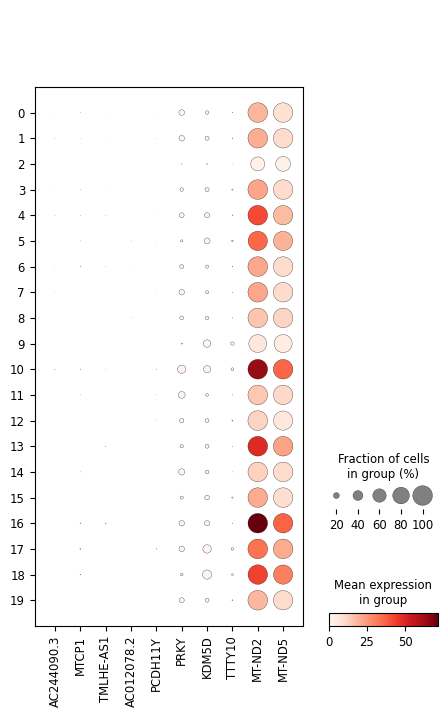

In [61]:
sc.pl.dotplot(data, keys, group_by)

In [62]:
adict = {
    "a": [1,0,3],
    "b": ["a","b","c"],
    "c": [0,0,0]
}

In [64]:
df = pl.DataFrame(adict)
df

a,b,c
i64,str,i64
1,"""a""",0
0,"""b""",0
3,"""c""",0


In [ ]:
from polars import selectors as cs

In [ ]:
cs

In [73]:
df = df.with_columns(pl.all().replace(0,None))
df

a,b,c
i64,str,i64
1,"""a""",null
null,"""b""",null
3,"""c""",null
